In [ ]:
import os
import sys; sys.path.insert(0, '..')
import seaborn as sns
import numpy as np
#sys.path.insert(1, os.path.join(sys.path[0], '..'))
from df_utils import df_wrapper, get_timestamp_and_pose
import pandas as pd
import timesync_utils as tutils
from tabulate import tabulate

In [ ]:
csv_f_name = "../../data/train_data/Simon_train_3.csv"
annot_f_name = "../../data/annotation/Simon_train_3.txt"


POSE_MAP = {
    "rett": 0,
    "fram": 1,
    "fram-hoyre": 2,
    "hoyre": 3,
    "bak-hoyre": 4,
    "bak": 5,
    "bak-venstre": 6,
    "venstre": 7,
    "fram-venstre": 8
}

In [ ]:
knn_train = df_wrapper(csv_f_name)
knn_train.concat_sensor_data(1)
knn_train.df

Splitting into  1  separate dataframes...
Fixing time offsets
Dropping unused columns...
Min length of sensor data:  60001


,TimeStamp (s),a_x,a_y,a_z,g_x,g_y,g_z,w_x,w_y,w_z,r_x,r_y,r_z,q_w,q_x,q_y,q_z
0,0.000000,-0.004732,-0.690689,-0.726169,0.534539,0.058521,-0.165964,0.0,0.0,0.0,47.377846,-0.609170,-45.406113,0.845599,-0.368757,0.159554,0.351459
1,0.009995,-0.002709,-0.698488,-0.724475,0.409979,0.054647,0.095046,0.0,0.0,0.0,47.381931,-0.609500,-45.405064,0.845589,-0.368787,0.159566,0.351445
2,0.019997,-0.003355,-0.695562,-0.726584,0.197535,-0.101003,0.048017,0.0,0.0,0.0,47.383907,-0.610535,-45.405483,0.845583,-0.368798,0.159581,0.351442
3,0.029999,-0.002963,-0.695249,-0.725356,0.109812,-0.219404,-0.035955,0.0,0.0,0.0,47.385029,-0.611754,-45.407349,0.845575,-0.368800,0.159599,0.351450
4,0.039993,-0.002754,-0.695206,-0.724380,0.217217,-0.303979,-0.087488,0.0,0.0,0.0,47.127167,-0.566297,-45.254425,0.846813,-0.367248,0.157983,0.350826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59996,599.960007,-0.153711,-0.962468,-0.193948,-0.202359,1.699549,-0.681699,0.0,0.0,0.0,78.837799,-8.630409,-102.535255,0.519256,-0.350830,0.530303,0.571026
59997,599.969955,-0.149983,-0.962639,-0.190256,0.686184,2.019532,-0.731934,0.0,0.0,0.0,78.841873,-8.619314,-102.516655,0.519292,-0.350995,0.530223,0.570965
59998,599.979965,-0.143293,-0.970871,-0.190805,1.290162,1.770548,-0.626909,0.0,0.0,0.0,78.852333,-8.609745,-102.500313,0.519303,-0.351171,0.530188,0.570880
59999,599.989975,-0.138863,-0.984151,-0.188710,1.167098,0.943729,-0.554751,0.0,0.0,0.0,78.877586,-8.571616,-102.526077,0.518945,-0.351376,0.530245,0.571027


[[0.0, 122.4, 0], [123.6, 240.96, 1], [243.2, 360.52, 7], [362.68, 482.12, 3], [484.2, 602.92, 5]]
Length of knn_train.df before drops: 60001
drops: 768
length of knn_train.df after drops: 59233
59233
59233


<AxesSubplot:xlabel=' TimeStamp (s)', ylabel='Pose'>

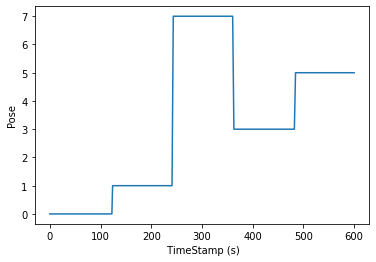

In [ ]:
stamped_poses = get_timestamp_and_pose(annot_f_name, POSE_MAP)
print(stamped_poses)
print("Length of knn_train.df before drops: {}".format(len(knn_train.df.index)))
knn_train.align_poses(stamped_poses)

print(len(knn_train.df.index))
# print(len(df_stamped_poses))
y_train = knn_train.df["Pose"]
# df['Pose'].hist(bins=4)
sns.lineplot(data=knn_train.df, x=" TimeStamp (s)", y='Pose')
#sns.histplot(data=knn_train.df['SensorId'])

<AxesSubplot:xlabel='Pose', ylabel='Count'>

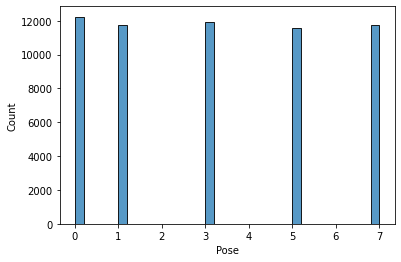

In [ ]:
sns.histplot(data=y_train)

In [ ]:
csv_file = "../../data/test_data/Simon_test_1.csv"
annot_file = "../../data/annotation/Simon_test_1.txt"

knn_test = df_wrapper(csv_file)
knn_test.concat_sensor_data(1)
knn_test.df

Splitting into  1  separate dataframes...
Fixing time offsets
Dropping unused columns...
Min length of sensor data:  6001


,TimeStamp (s),AccX (g),AccY (g),AccZ (g),GyroX (deg/s),GyroY (deg/s),GyroZ (deg/s),MagX (uT),MagY (uT),MagZ (uT),EulerX (deg),EulerY (deg),EulerZ (deg),QuatW,QuatX,QuatY,QuatZ
0,0.000000,0.062783,-0.664359,-0.745311,-1.486327,-0.954215,-1.100742,0.0,0.0,0.0,45.977032,2.722177,-50.473026,0.828528,-0.362494,0.146685,0.400777
1,0.010000,0.068403,-0.668227,-0.748759,0.846733,-0.104457,-2.227663,0.0,0.0,0.0,45.984718,2.737466,-50.489273,0.828422,-0.362581,0.146652,0.400930
2,0.020000,0.071032,-0.672759,-0.749368,0.630087,-0.068906,-1.911747,0.0,0.0,0.0,45.729458,2.834796,-50.418976,0.829316,-0.361150,0.144826,0.401037
3,0.030001,0.073829,-0.674456,-0.750533,0.789155,0.104108,-1.864622,0.0,0.0,0.0,45.736748,2.848875,-50.431267,0.829227,-0.361234,0.144787,0.401159
4,0.039999,0.074100,-0.673934,-0.749086,0.912611,-0.007038,-1.740844,0.0,0.0,0.0,45.745266,2.861296,-50.443478,0.829138,-0.361322,0.144765,0.401274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5996,59.959995,0.288413,-0.607716,-0.857441,16.279032,-0.668786,-7.142547,0.0,0.0,0.0,33.901562,12.762970,-46.368332,0.861102,-0.308202,0.016335,0.404039
5997,59.969997,0.267898,-0.616100,-0.847874,16.176073,-1.929723,-5.452105,0.0,0.0,0.0,34.064842,12.784996,-46.423275,0.860428,-0.309486,0.016889,0.404472
5998,59.980000,0.243766,-0.607581,-0.840962,16.973791,-2.367597,-3.386166,0.0,0.0,0.0,34.225212,12.784409,-46.465641,0.859845,-0.310682,0.017575,0.404764
5999,59.990002,0.226962,-0.590494,-0.836024,18.708357,-3.271112,-2.419889,0.0,0.0,0.0,34.403584,12.771029,-46.505039,0.859246,-0.311974,0.018415,0.405005


[[0.0, 12.28, 0], [12.6, 22.64, 1], [24.16, 31.64, 7], [32.76, 42.0, 3], [42.64, 58.64, 5]]
drops: 496
length of knn_train.df after drops: 5505
5505


<AxesSubplot:xlabel=' TimeStamp (s)', ylabel='Pose'>

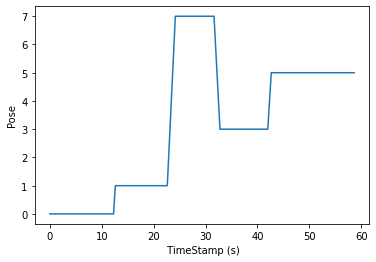

In [ ]:
s_poses = get_timestamp_and_pose(annot_file, POSE_MAP)

print(s_poses)
knn_test.align_poses(s_poses)

y_test = knn_test.df["Pose"]  # df_test["Pose"]

sns.lineplot(data=knn_test.df, x=" TimeStamp (s)", y='Pose')

<AxesSubplot:xlabel='Pose', ylabel='Count'>

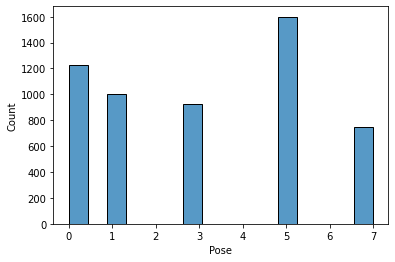

In [ ]:
sns.histplot(data=y_test)

In [ ]:
#print(knn_train.df)
x_train = knn_train.df.drop([' TimeStamp (s)', 'Pose'],axis=1)
x_test = knn_test.df.drop([' TimeStamp (s)', 'Pose'], axis=1) 

x_train_numpy = x_train.values
x_test_numpy = x_test.values

In [ ]:
len(POSE_MAP)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)



(59233, 16)
(5505, 16)
(59233,)


### Keras Model

Leger en enkel modell

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

LR = 0.001
EPOCH = 100
AMOUNT_OF_SENSORS = 3

"""
model = tf.keras.Sequential()
model.add(Dense(16, input_dim activation='relu'))
model.add(Dense(13, activation='relu'))
model.add(Dense(9,activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
"""

class Model:
    def __init__(input_shape=(AMOUNT_OF_SENSORS*16)+1, output_shape=len(POSE_MAP), lr=LR):
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.lr = lr
        self.m = tf.keras.Sequential([
            tf.keras.layers.add(Dense(input_dim=input_shape, activation='relu')),
            tf.keras.layers.add(Dense(13, activation='relu')),
            tf.keras.layers.add(Dense(output_shape,activation='softmax'))
        ])
        self.m.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])    


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

model = tf.keras.Sequential()
model.add(Dense(16,input_dim=16, activation='relu'))
model.add(Dense(12,activation='relu'))
model.add(Dense(9,activation='sigmoid'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(np.array(x_train), np.array(y_train), epochs=10, batch_size=64)

Epoch 1/10
926/926 [==============================] - 2s 2ms/step - loss: 1.3410 - accuracy: 0.6941
Epoch 2/10
926/926 [==============================] - 2s 2ms/step - loss: 0.0469 - accuracy: 0.9997
Epoch 3/10
926/926 [==============================] - 2s 2ms/step - loss: 0.0081 - accuracy: 1.0000
Epoch 4/10
926/926 [==============================] - 2s 2ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 5/10
926/926 [==============================] - 2s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 6/10
926/926 [==============================] - 2s 2ms/step - loss: 5.2023e-04 - accuracy: 1.0000
Epoch 7/10
926/926 [==============================] - 2s 2ms/step - loss: 2.7365e-04 - accuracy: 1.0000
Epoch 8/10
926/926 [==============================] - 2s 2ms/step - loss: 1.5422e-04 - accuracy: 1.0000
Epoch 9/10
926/926 [==============================] - 2s 2ms/step - loss: 8.3188e-05 - accuracy: 1.0000
Epoch 10/10
926/926 [==============================] - 2s 2ms/step - loss: 4.7064e-0

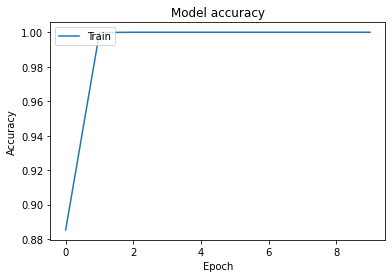

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
"""
#Normalizing the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
"""

'\n#Normalizing the data\nfrom sklearn.preprocessing import StandardScaler\nsc = StandardScaler()\nX = sc.fit_transform(X)\n'

In [ ]:

#history = model.fit(x_train, y_train, epochs=EPOCH,batch_size=64)

dataset = tf.data.Dataset.from_tensor_slices((x_train.values, y_train.values))

for feat, targ in dataset.take(5):
  print ('Features: {}, Target: {}'.format(feat, targ))

train_dataset = dataset.shuffle(len(x_train)).batch(1)
Model().m.fit(train_dataset, epochs=EPOCH)

Features: [-4.73247934e-03 -6.90689087e-01 -7.26168573e-01  5.34539163e-01
  5.85214347e-02 -1.65963784e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  4.73778458e+01 -6.09170318e-01 -4.54061127e+01
  8.45598876e-01 -3.68756503e-01  1.59554228e-01  3.51459473e-01], Target: 0
Features: [-2.70891283e-03 -6.98487520e-01 -7.24475265e-01  4.09979075e-01
  5.46473712e-02  9.50464830e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  4.73819313e+01 -6.09499812e-01 -4.54050636e+01
  8.45589399e-01 -3.68787080e-01  1.59565821e-01  3.51444989e-01], Target: 0
Features: [-3.35460063e-03 -6.95561826e-01 -7.26583779e-01  1.97534800e-01
 -1.01002775e-01  4.80166040e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  4.73839073e+01 -6.10534787e-01 -4.54054832e+01
  8.45583081e-01 -3.68797868e-01  1.59580871e-01  3.51441979e-01], Target: 0
Features: [-2.96269450e-03 -6.95249438e-01 -7.25355625e-01  1.09811984e-01
 -2.19403520e-01 -3.59554030e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+

NameError: name 'self' is not defined

### Pytorch Model

Lager en enkel modell med 2 lineære lag

In [ ]:
"""
import torch
import torch.nn as nn
import torch.optim as optim

class Model(nn.Module):
    def __init__(self, input_shape=49, output_shape=9, lr=0.001):
        super(Model, self).__init__()
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.lr = lr
        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_shape, 25),
            torch.nn.ReLU(),
            torch.nn.Linear(25, output_shape),
        )
        self.opt = optim.SGD(self.net.parameters(), lr=lr, momentum=0.9)
        #self.opt = optim.Adam(self.net.parameters(), lr=lr)
        #self.opt = optim.RMSprop(self.net.parameters(), lr=lr)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.net(x)
    
    def accuracy(self, x, y):
        return torch.mean(torch.eq(self.forward(x).argmax(1), y.argmax(1)).float())

    """
    # Uses Cross Entropy
    def loss(self, x, y):
        return torch.nn.functional.binary_cross_entropy_with_logits(self.f(x), y)
    """
    def loss(self, x, y):
        return self.criterion(self.forward(x), y)
"""

### Training

Denne er hentet ut fra [Pytorch egen nettside](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [ ]:
"""
LR = 0.001
EPOCH = 100
AMOUNT_OF_SENSORS = 3

model = Model(input_shape=(AMOUNT_OF_SENSORS*16)+1, output_shape=len(POSE_MAP), lr=LR)

Vi må dele opp i rader og skille ut en 7tensor med dataattributter og en tensor med labels
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(x_train, 0):
        # zero the parameter gradients
        model.opt.zero_grad()

        # forward + backward + optimize
        outputs = model.forward(inputs)
        loss = model.criterion(outputs, labels)
        loss.backward()
        model.opt.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

results = []
for index, epoch in enumerate(range(EPOCH)):
    model.opt.zero_grad()

    # forward + backward + optimize
    loss = model.loss(torch.tensor(x_train.values), torch.tensor(y_train.values))
    loss.backward()
    model.opt.step()

    if (index+1) % 10 == 0:
        print(f'epoch = {index+1}, loss = {model.loss(x_train, y_train).item()}, accuracy = {model.accuracy(x_test, y_test).item() * 100}%')
        results.append([index+1, model.loss(x_train, y_train).item(),
                        model.accuracy(x_test, y_test).item() * 100])

    model.loss(x_train, y_train).backward()  # Compute loss gradients
    model.opt.step()  # Perform optimization by adjusting W and b

print(tabulate.tabulate(results, headers=['epoch', 'loss', 'accuracy']))
"""

RuntimeError: mat1 and mat2 shapes cannot be multiplied (59233x16 and 49x25)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=59d486bc-e14d-4632-9064-12272fc72d11' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>